In [89]:
import pandas as pd
import numpy as np
import xgboost as xgb
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

data = pd.read_csv("datasets/all_maps_kill_data.csv")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153919 entries, 0 to 153918
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   map_name            153919 non-null  object 
 1   match_id            153919 non-null  int64  
 2   round_number        153919 non-null  int64  
 3   time                153919 non-null  int64  
 4   player_id           153919 non-null  int64  
 5   side                153919 non-null  object 
 6   round_outcome       153919 non-null  object 
 7   plant_time          109805 non-null  float64
 8   plant_site          109805 non-null  object 
 9   weapon_id           153901 non-null  float64
 10  kill_id             153919 non-null  int64  
 11  killer_id           153919 non-null  int64  
 12  victim_id           153919 non-null  int64  
 13  kill_weapon_id      147993 non-null  float64
 14  kill_ability_id     2634 non-null    float64
 15  victim_x            153919 non-nul

In [86]:
os.makedirs("models", exist_ok=True)
os.makedirs("visualizations", exist_ok=True)

map_files = glob("datasets/map_kill_data/*_kill_data.csv")
print(f"Found {len(map_files)} map data files:")
for file in map_files:
    print(f"- {os.path.basename(file)}")

Found 9 map data files:
- icebox_kill_data.csv
- pearl_kill_data.csv
- ascent_kill_data.csv
- split_kill_data.csv
- abyss_kill_data.csv
- haven_kill_data.csv
- fracture_kill_data.csv
- bind_kill_data.csv
- lotus_kill_data.csv


In [100]:
def train_map_model(file_path):
    map_name = os.path.basename(file_path).split("_")[0]
    print(f"Training model for {map_name}...")
    df = pd.read_csv(file_path)
    print(f"Loaded {len(df)} rows of data.")
    
    df.fillna({
        "weapon_id": -1,
        "kill_weapon_id": -1,
        "traded_by_kill_id": -1,
        "traded_for_kill_id": -1
    }, inplace=True)
    
    # Features + Targets
    df["distance"] = np.sqrt((df["killer_x"] - df["victim_x"]) ** 2 + (df["killer_y"] - df["victim_y"]) ** 2)
    df["attacker_won"] = (df["side"] == "atk").astype(int)
    df[["weapon_id", "kill_weapon_id"]] = df[["weapon_id", "kill_weapon_id"]].astype(int)
    df["is_first_kill"] = df["first_kill"].astype(int)
    df["is_traded"] = df["traded_by_kill_id"].notna().astype(int)
    
    # Time-based tactical advantage features
    # 1. Early round defender advantage (first 20 seconds)
    early_round_time = 20000  # 20 seconds in milliseconds
    df["is_early_round"] = (df["time"] < early_round_time).astype(int)
    
    # 2. Post-plant attacker advantage
    df["is_post_plant"] = (df["time"] > df["plant_time"]).astype(int)
    
    # 3. Tactical advantage score (-1 to 1 scale)
    # -1: strong attacker advantage, 0: neutral, 1: strong defender advantage
    df["tactical_advantage"] = np.where(
        df["is_post_plant"] == 1, 
        -1,  # Post-plant: attacker advantage
        np.where(
            df["is_early_round"] == 1,
            1,  # Early round: defender advantage
            0   # Mid-round: neutral
        )
    )
    
    # 4. Round phase (categorical)
    df["round_phase"] = pd.cut(
        df["time"],
        bins=[0, 20000, 60000, np.inf],
        labels=["early", "mid", "late"]
    )
    round_phase_encoder = LabelEncoder()
    df["round_phase_encoded"] = round_phase_encoder.fit_transform(df["round_phase"])
    
    if "plant_site" in df.columns and not df["plant_site"].isna().all():
        site_encoder = LabelEncoder()
        df["site_encoded"] = site_encoder.fit_transform(df["plant_site"].fillna("None"))
        has_site_data = True
    else:
        has_site_data = False
    
    # Define features
    base_features = [
        "killer_x", "killer_y", "victim_x", "victim_y",
        "distance", "weapon_id", "kill_weapon_id",
        "is_first_kill", "is_traded",
        "is_early_round", "is_post_plant", "tactical_advantage", "round_phase_encoded"
    ]
    features = base_features + (["site_encoded"] if has_site_data else [])
    
    X = df[features].copy()
    y = df["attacker_won"]
    
    # Split and train
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Training set: {len(X_train)} rows, Test set: {len(X_test)} rows")
    
    dtrain = xgb.DMatrix(X_train, label = y_train)
    dtest = xgb.DMatrix(X_test, label = y_test)
    
    params = {
        "max_depth": 6,
        "eta": 0.3,
        "objective": "binary:logistic",
        "subsample": 0.8,
        "seed": 42
    }
    
    model = xgb.train(params, dtrain, 100, [(dtrain, "train"), (dtest, "test")], early_stopping_rounds=10, verbose_eval=20)
    
    y_pred_probability = model.predict(dtest)
    y_pred = (y_pred_probability > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Print feature importance
    importance = model.get_score(importance_type="weight")
    importance_df = pd.DataFrame({
        "Feature": list(importance.keys()),
        "Importance": list(importance.values())
    }).sort_values("Importance", ascending=False)
    print("\nTop 10 important features:")
    print(importance_df.head(10))
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=importance_df)
    plt.title(f"Feature Importance for {map_name.capitalize()}")
    plt.tight_layout()
    plt.savefig(f"visualizations/{map_name}_feature_importance.png")
    plt.close()
    
    # Create and save confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
               xticklabels=["Defender Win", "Attacker Win"],
               yticklabels=["Defender Win", "Attacker Win"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {map_name.capitalize()}")
    plt.tight_layout()
    plt.savefig(f"visualizations/{map_name}_confusion_matrix.png")
    plt.close()
    
    model_path = f"models/{map_name}_duel_model.json"
    model.save_model(model_path)
    print(f"Model saved to {model_path}")
    
    feature_dict = {
        "features": features,
        "has_site_data": has_site_data
    }
    if has_site_data:
        feature_dict["site_classes"] = site_encoder.classes_.tolist()
    
    return model, accuracy, feature_dict, map_name

In [101]:
results = []
models = {}
feature_configs = {}

for file in map_files:
    model, accuracy, feature_dict, map_name = train_map_model(file)
    
    if model is not None:
        models[map_name] = model
        feature_configs[map_name] = feature_dict
        results.append({
            'map': map_name,
            'accuracy': accuracy,
            'features': len(feature_dict['features'])
        })

# Display results summary
results_df = pd.DataFrame(results)
print("\n=== Model Results Summary ===")
print(results_df.sort_values('accuracy', ascending=False))

with open("models/feature_configs.json", "w") as f:
    json.dump(feature_configs, f)

Training model for icebox...
Loaded 12996 rows of data.
Training set: 10396 rows, Test set: 2600 rows
[0]	train-logloss:0.66926	test-logloss:0.67609


[20]	train-logloss:0.56800	test-logloss:0.65727
[24]	train-logloss:0.56157	test-logloss:0.66630
Accuracy: 0.5642

Top 10 important features:
                Feature  Importance
3              victim_y       194.0
1              killer_y       193.0
5             weapon_id       183.0
0              killer_x       148.0
2              victim_x       141.0
4              distance       130.0
6        kill_weapon_id       124.0
11         site_encoded        39.0
9         is_post_plant        19.0
10  round_phase_encoded        18.0


/home/joshhwuu/.local/lib/python3.10/site-packages/xgboost/core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Model saved to models/icebox_duel_model.json
Training model for pearl...
Loaded 20969 rows of data.
Training set: 16775 rows, Test set: 4194 rows
[0]	train-logloss:0.67077	test-logloss:0.67486
[19]	train-logloss:0.58553	test-logloss:0.64619
Accuracy: 0.6106

Top 10 important features:
                Feature  Importance
1              killer_y       179.0
3              victim_y       164.0
5             weapon_id       157.0
6        kill_weapon_id       134.0
0              killer_x       130.0
4              distance       110.0
2              victim_x        97.0
11         site_encoded        31.0
10  round_phase_encoded        16.0
9         is_post_plant        15.0


/home/joshhwuu/.local/lib/python3.10/site-packages/xgboost/core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Model saved to models/pearl_duel_model.json
Training model for ascent...
Loaded 11301 rows of data.
Training set: 9040 rows, Test set: 2261 rows
[0]	train-logloss:0.65801	test-logloss:0.66713
[15]	train-logloss:0.57549	test-logloss:0.64305
Accuracy: 0.6002

Top 10 important features:
                Feature  Importance
1              killer_y       112.0
3              victim_y       106.0
5             weapon_id       106.0
6        kill_weapon_id        86.0
2              victim_x        82.0
4              distance        79.0
0              killer_x        74.0
11         site_encoded        31.0
10  round_phase_encoded        11.0
9         is_post_plant         9.0


/home/joshhwuu/.local/lib/python3.10/site-packages/xgboost/core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Model saved to models/ascent_duel_model.json
Training model for split...
Loaded 23021 rows of data.
Training set: 18416 rows, Test set: 4605 rows
[0]	train-logloss:0.67066	test-logloss:0.67334
[19]	train-logloss:0.59336	test-logloss:0.65087
Accuracy: 0.5991

Top 10 important features:
                Feature  Importance
5             weapon_id       161.0
1              killer_y       155.0
3              victim_y       154.0
2              victim_x       141.0
0              killer_x       126.0
6        kill_weapon_id       115.0
4              distance        96.0
12         site_encoded        37.0
9         is_post_plant        23.0
11  round_phase_encoded        22.0


/home/joshhwuu/.local/lib/python3.10/site-packages/xgboost/core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Model saved to models/split_duel_model.json
Training model for abyss...
Loaded 9415 rows of data.
Training set: 7532 rows, Test set: 1883 rows
[0]	train-logloss:0.66831	test-logloss:0.67828
[13]	train-logloss:0.58848	test-logloss:0.69477
Accuracy: 0.5327

Top 10 important features:
                Feature  Importance
0              killer_x       118.0
5             weapon_id       101.0
2              victim_x       100.0
1              killer_y        88.0
3              victim_y        84.0
4              distance        77.0
6        kill_weapon_id        72.0
12         site_encoded        23.0
11  round_phase_encoded        14.0
9         is_post_plant         9.0


/home/joshhwuu/.local/lib/python3.10/site-packages/xgboost/core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Model saved to models/abyss_duel_model.json
Training model for haven...
Loaded 21287 rows of data.
Training set: 17029 rows, Test set: 4258 rows
[0]	train-logloss:0.67432	test-logloss:0.67749
[15]	train-logloss:0.60285	test-logloss:0.64928
Accuracy: 0.6109

Top 10 important features:
                Feature  Importance
1              killer_y       152.0
5             weapon_id       139.0
3              victim_y       113.0
6        kill_weapon_id       108.0
0              killer_x        96.0
2              victim_x        89.0
4              distance        65.0
12         site_encoded        34.0
9         is_post_plant        10.0
11  round_phase_encoded        10.0


/home/joshhwuu/.local/lib/python3.10/site-packages/xgboost/core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Model saved to models/haven_duel_model.json
Training model for fracture...
Loaded 17519 rows of data.
Training set: 14015 rows, Test set: 3504 rows
[0]	train-logloss:0.67592	test-logloss:0.68314
[13]	train-logloss:0.62567	test-logloss:0.68299
Accuracy: 0.5465

Top 10 important features:
                Feature  Importance
5             weapon_id       129.0
2              victim_x       108.0
1              killer_y       105.0
3              victim_y        94.0
0              killer_x        90.0
4              distance        81.0
6        kill_weapon_id        74.0
11         site_encoded        42.0
9         is_post_plant        21.0
10  round_phase_encoded        19.0


/home/joshhwuu/.local/lib/python3.10/site-packages/xgboost/core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Model saved to models/fracture_duel_model.json
Training model for bind...
Loaded 8802 rows of data.
Training set: 7041 rows, Test set: 1761 rows
[0]	train-logloss:0.66816	test-logloss:0.68033
[16]	train-logloss:0.56670	test-logloss:0.67038
Accuracy: 0.5764

Top 10 important features:
                Feature  Importance
1              killer_y       139.0
3              victim_y       131.0
5             weapon_id       107.0
4              distance        97.0
0              killer_x        88.0
2              victim_x        79.0
6        kill_weapon_id        79.0
12         site_encoded        20.0
11  round_phase_encoded        13.0
9         is_post_plant        10.0


/home/joshhwuu/.local/lib/python3.10/site-packages/xgboost/core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Model saved to models/bind_duel_model.json
Training model for lotus...
Loaded 28609 rows of data.
Training set: 22887 rows, Test set: 5722 rows
[0]	train-logloss:0.67853	test-logloss:0.68216
[20]	train-logloss:0.61009	test-logloss:0.65183
[29]	train-logloss:0.59819	test-logloss:0.65992
Accuracy: 0.5846

Top 10 important features:
                Feature  Importance
1              killer_y       267.0
5             weapon_id       247.0
3              victim_y       212.0
6        kill_weapon_id       190.0
2              victim_x       149.0
4              distance       124.0
0              killer_x       123.0
12         site_encoded        52.0
9         is_post_plant        26.0
11  round_phase_encoded        13.0


/home/joshhwuu/.local/lib/python3.10/site-packages/xgboost/core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Model saved to models/lotus_duel_model.json

=== Model Results Summary ===
        map  accuracy  features
5     haven  0.610850        14
1     pearl  0.610634        14
2    ascent  0.600177        14
3     split  0.599131        14
8     lotus  0.584586        14
7      bind  0.576377        14
0    icebox  0.564231        14
6  fracture  0.546518        14
4     abyss  0.532661        14


In [96]:
def predict_duel(model, map_name, killer_pos, victim_pos, killer_weapon, 
                victim_weapon, round_time, plant_time=None, is_first_kill=False, site=None):
    """Predict outcome of a duel with tactical time features"""
    
    # Get the feature configuration for this map
    if map_name not in feature_configs:
        raise ValueError(f"No feature configuration found for map: {map_name}")
    
    feature_config = feature_configs[map_name]
    feature_names = feature_config["features"]
    
    # Calculate distance
    distance = np.sqrt((killer_pos[0] - victim_pos[0])**2 + 
                      (killer_pos[1] - victim_pos[1])**2)
    
    # Calculate time-based tactical advantages
    is_early_round = 1 if round_time < 20000 else 0
    is_post_plant = 1 if plant_time and round_time > plant_time else 0
    
    tactical_advantage = -1 if is_post_plant else (1 if is_early_round else 0)
    
    # Determine round phase
    if round_time < 20000:
        round_phase_encoded = 0
    elif round_time < 60000:
        round_phase_encoded = 1
    else:
        round_phase_encoded = 2
    
    # Create feature dictionary
    feature_dict = {
        "killer_x": killer_pos[0],
        "killer_y": killer_pos[1],
        "victim_x": victim_pos[0],
        "victim_y": victim_pos[1],
        "distance": distance,
        "weapon_id": killer_weapon,
        "kill_weapon_id": victim_weapon,
        "is_first_kill": int(is_first_kill),
        "is_traded": 0,
        "is_early_round": is_early_round,
        "is_post_plant": is_post_plant,
        "tactical_advantage": tactical_advantage,
        "round_phase_encoded": round_phase_encoded
    }
    
    # Add site_encoded if the model has it
    if feature_config["has_site_data"]:
        if site is None:
            # Default to "None" if no site is specified
            site_classes = feature_config.get("site_classes", ["None"])
            site_idx = site_classes.index("None") if "None" in site_classes else 0
        else:
            # Find the index of the specified site
            site_classes = feature_config.get("site_classes", [])
            if site in site_classes:
                site_idx = site_classes.index(site)
            else:
                site_idx = site_classes.index("None") if "None" in site_classes else 0
        
        feature_dict["site_encoded"] = site_idx
    
    # Create feature array in the correct order
    features = [[feature_dict[feature_name] for feature_name in feature_names]]
    
    # Create DMatrix with feature names
    dmatrix = xgb.DMatrix(np.array(features), feature_names=feature_names)
    
    # Get prediction probability
    probability = float(model.predict(dmatrix)[0])
    
    # Return formatted results
    return {
        "prediction": "Attacker wins" if probability > 0.5 else "Defender wins",
        "attacker_win_probability": probability,
        "defender_win_probability": 1 - probability
    }


=== Early Round Duel (Defender Advantage) ===
Prediction: Attacker wins
Attacker win probability: 55.89%
Defender win probability: 44.11%

=== Mid-Round Duel (Neutral) ===
Prediction: Attacker wins
Attacker win probability: 53.58%
Defender win probability: 46.42%

=== Post-Plant Duel (Attacker Advantage) ===
Prediction: Attacker wins
Attacker win probability: 67.51%
Defender win probability: 32.49%

=== Weapon Matchup Analysis ===
   attacker_weapon  defender_weapon  attacker_win_prob
0                9                9           0.239924
1                9               12           0.280253
2                9               15           0.482390
3               12                9           0.694339
4               12               12           0.444657
5               12               15           0.633192


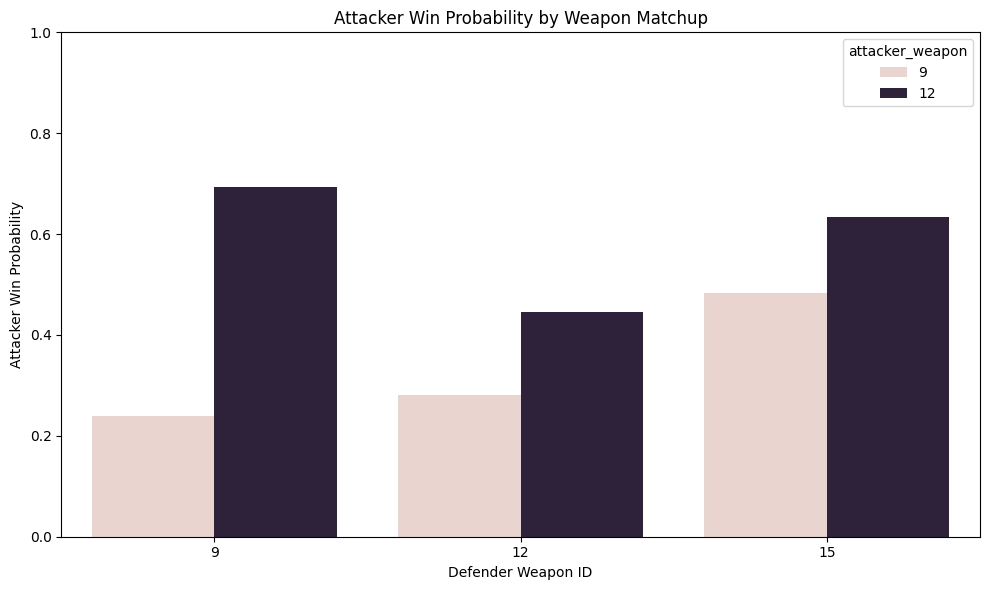

In [102]:
# Example 1: Early round duel
early_duel = predict_duel(
    model=models["ascent"],  # Assuming you have an Ascent model
    map_name="ascent", 
    killer_pos=(100, 200),   # Position on A site
    victim_pos=(150, 250),   # Nearby position
    killer_weapon=12,        # 12 = Phantom
    victim_weapon=9,         # 9 = Vandal
    round_time=10000,        # 10 seconds into round (early)
    plant_time=None,         # No bomb planted yet
    is_first_kill=True       # First engagement of the round
)

print("\n=== Early Round Duel (Defender Advantage) ===")
print(f"Prediction: {early_duel['prediction']}")
print(f"Attacker win probability: {early_duel['attacker_win_probability']:.2%}")
print(f"Defender win probability: {early_duel['defender_win_probability']:.2%}")

# Example 2: Mid-round duel
mid_duel = predict_duel(
    model=models["bind"],    # Using Bind model
    map_name="bind", 
    killer_pos=(300, 400),   # Position in mid
    victim_pos=(320, 430),   # Nearby position
    killer_weapon=12,        # Phantom
    victim_weapon=12,        # Also Phantom
    round_time=45000,        # 45 seconds into round (mid-round)
    plant_time=None,         # No plant yet
    is_first_kill=False      # Not first kill
)

print("\n=== Mid-Round Duel (Neutral) ===")
print(f"Prediction: {mid_duel['prediction']}")
print(f"Attacker win probability: {mid_duel['attacker_win_probability']:.2%}")
print(f"Defender win probability: {mid_duel['defender_win_probability']:.2%}")

# Example 3: Post-plant duel
post_plant_duel = predict_duel(
    model=models["haven"],   # Using Haven model
    map_name="haven", 
    killer_pos=(500, 300),   # Position near planted bomb
    victim_pos=(550, 320),   # Nearby position
    killer_weapon=9,         # Vandal
    victim_weapon=15,        # Operator
    round_time=75000,        # 75 seconds into round (late)
    plant_time=60000,        # Bomb planted at 60 seconds
    is_first_kill=False
)

print("\n=== Post-Plant Duel (Attacker Advantage) ===")
print(f"Prediction: {post_plant_duel['prediction']}")
print(f"Attacker win probability: {post_plant_duel['attacker_win_probability']:.2%}")
print(f"Defender win probability: {post_plant_duel['defender_win_probability']:.2%}")

# Example 4: Analyzing weapon advantage
weapon_matchups = []
attacker_weapons = [9, 12]   # Vandal, Phantom
defender_weapons = [9, 12, 15]  # Vandal, Phantom, Operator

for atk_weapon in attacker_weapons:
    for def_weapon in defender_weapons:
        result = predict_duel(
            model=models["split"],
            map_name="split",
            killer_pos=(400, 350),
            victim_pos=(450, 370),
            killer_weapon=atk_weapon,
            victim_weapon=def_weapon,
            round_time=30000,
            is_first_kill=False
        )
        weapon_matchups.append({
            "attacker_weapon": atk_weapon,
            "defender_weapon": def_weapon,
            "attacker_win_prob": result["attacker_win_probability"]
        })

# Convert to DataFrame and display as table
matchup_df = pd.DataFrame(weapon_matchups)
print("\n=== Weapon Matchup Analysis ===")
print(matchup_df)

# Visualize weapon matchups
plt.figure(figsize=(10, 6))
sns.barplot(data=matchup_df, x="defender_weapon", y="attacker_win_prob", hue="attacker_weapon")
plt.title("Attacker Win Probability by Weapon Matchup")
plt.xlabel("Defender Weapon ID")
plt.ylabel("Attacker Win Probability")
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("visualizations/weapon_matchup_analysis.png")
plt.show()